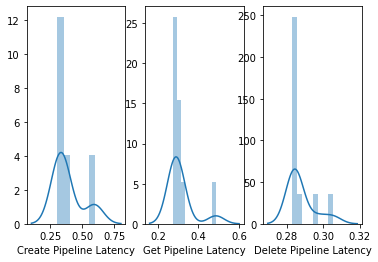

In [30]:
import random
import kfp
import kfp_server_api
import os
import string
import time
from datetime import datetime, timezone, timedelta

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# CHANGE necessary paramters here
# host is your KFP endpoint
host = 'http://127.0.0.1:3000'
num_pipelines = 10
# Use the pipeline you prefer
pipeline_file_url = 'https://storage.googleapis.com/jingzhangjz-project-pipelines/benchmarks/taxi.yaml'


def random_suffix() -> string:
    return ''.join(random.choices(string.ascii_lowercase + string.digits, k=10))


if __name__ == '__main__':
    client = kfp.Client(host)
    
    # Create pipeline latency
    create_latencies = []
    created_pipeline_ids = []
    for i in range(num_pipelines):
        api_url = kfp_server_api.models.ApiUrl(pipeline_file_url)
        api_pipeline = kfp_server_api.models.ApiPipeline(
            name='pipeline-' + random_suffix(),
            url=api_url)
        start = time.perf_counter()
        pipeline = client.pipelines.create_pipeline(body=api_pipeline)
        dur = time.perf_counter() - start
        create_latencies.append(dur)
        created_pipeline_ids.append(pipeline.id)
        
    # Get pipeline latency
    get_latencies = []
    for i in created_pipeline_ids:
        start = time.perf_counter()
        pipeline = client.pipelines.get_pipeline(i)  
        dur = time.perf_counter() - start
        get_latencies.append(dur)      
        
    # Delete pipeline latency
    delete_latencies= []
    for i in created_pipeline_ids:
        start = time.perf_counter()
        pipeline = client.pipelines.delete_pipeline(i)  
        dur = time.perf_counter() - start
        delete_latencies.append(dur)

    # Plot
    fig, axs = plt.subplots(ncols=3)
    label_create_latencies = pd.Series(create_latencies, name='Create Pipeline Latency')
    sns.distplot(a=label_create_latencies, ax=axs[0])
    label_get_latencies = pd.Series(get_latencies, name='Get Pipeline Latency')
    sns.distplot(a=label_get_latencies, ax=axs[1])
    label_delete_latencies = pd.Series(delete_latencies, name='Delete Pipeline Latency')
    sns.distplot(a=label_delete_latencies, ax=axs[2])
    
    # TODO(jingzhang36): maybe dump the durations data to db or gcs, and let searborn read from there